# Using the Topological Advection Algorithm

## Bounded Trajectories Case

Let's look at how to use the topological advection algorithm.  In this notebook we will consider the case of trajectories that are within a bounded region of the plane.  We will generate some trajectories and then get to work.

In [2]:
import numpy as np
import sys
import scipy.io as sio
sys.path.append("../src")  # accessing the source folder
import topological_advection as TA
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

### Example System

Let's use chaotic lid-driven cavity flow as example system.  A description of this analytically defined flow can be found [in this arXiv paper](https://arxiv.org/abs/1809.01005).  We provide $\vec{V}(x,y,t)$ and use an ODE solver to get the trajectories from $\frac{d \vec{r}}{dt} = \vec{V}(x,y,t)$.

In [4]:
# global parameters 
U1 = 9.92786
U2 = 8.34932 
a = 6
b = 1
tau = 0.96
params = [a,b,U1,U2,tau]

# Computational Parameters
T_i = 0  # Starting time
T_f = 4  # final time (seconds)
# Rectangular Domain
x_l = 0  # x-range left
x_r = params[0] #x-range right
y_b = -1*params[1]   #Rectangular Domain, y-range bottom
y_t = params[1]   #Rectangular Domain, y-range top

T_num = 100 # number of time-steps to take
#  will use equally spaceed time-steps, though this is not neccesary
dt = (T_f-T_i)/T_num   # The time-step to use
times =  np.arange(T_i, T_f, dt)  #the set of times used in the ode solver

# the velocity vector function
def VelFunc(t,z,p):    
    x,y = z
    a, b, U1, U2, tau = p
    div = t/tau - np.floor(t/tau)
    Vx, Vy = 0, 0
    if div<0.5:
        Vx = (U1*CFunc(1,a,b)*derivativefFunc(1,y,a,b)*np.sin(np.pi*x/a)
              + U2*CFunc(2,a,b)*derivativefFunc(2,y,a,b)*np.sin(2*np.pi*x/a))
        Vy = (-U1*CFunc(1,a,b)*fFunc(1,y,a,b)*np.pi*np.cos(np.pi*x/a)/a
              - U2*CFunc(2,a,b)*fFunc(2,y,a,b)*2*np.pi*np.cos(2*np.pi*x/a)/a)
    else:
        Vx = (-U1*CFunc(1,a,b)*derivativefFunc(1,y,a,b)*np.sin(np.pi*x/a)
              + U2*CFunc(2,a,b)*derivativefFunc(2,y,a,b)*np.sin(2*np.pi*x/a))
        Vy = (U1*CFunc(1,a,b)*fFunc(1,y,a,b)*np.pi*np.cos(np.pi*x/a)/a
              - U2*CFunc(2,a,b)*fFunc(2,y,a,b)*2*np.pi*np.cos(2*np.pi*x/a)/a)
    return [Vx,Vy]

def CFunc(k,a,b): # Helper C_k function
    return ((a**2/(2*k*(np.pi**2)*b)) * 
            (1/((a/(2*k*np.pi*b)) * 
                np.sinh(2*k*np.pi*b/a)+1)))

def fFunc(k,y,a,b): # Helper F_k function
    return (2*np.pi*y*np.cosh(k*np.pi*b/a)*np.sinh(k*np.pi*y/a)/a
              - 2*np.pi*b*np.sinh(k*np.pi*b/a)*np.cosh(k*np.pi*y/a)/a)

def derivativefFunc(k,y,a,b): # Helper derivative of F_k function
    return (2*np.pi*np.cosh(k*np.pi*b/a)*np.sinh(k*np.pi*y/a)/a
            + 2*k*(np.pi**2)*y*np.cosh(k*np.pi*b/a)*np.cosh(k*np.pi*y/a)/(a**2)
            - 2*k*(np.pi**2)*b*np.sinh(k*np.pi*b/a)*np.sinh(k*np.pi*y/a)/(a**2))

# Initialize the particles with random positions in the domain
Ntot =  200  # the total number of initial points to seed
de = 0.1  # Small factor to get points away from the edge
InitCond = [] # list of the initial conditions
for i in range(Ntot):
    InitCond.append([np.random.uniform(x_l+de, x_r-de),
                     np.random.uniform(y_b+de, y_t-de)])

# Now we run each inital condition through the ode solver
Traj = np.array([solve_ivp(fun=VelFunc, t_span=(T_i,T_f), y0=IC,
                    method='Radau', t_eval=times, args=(params,)).y.T for IC in InitCond])

### How to Structure Trajectory Data

Now we can illustrate features of the topological advection algorithm with this trajectory set.  The very first thing to to is make sure that we have the correct data structure for the trajectories.  Currently Traj has the signature Traj[trajectory id][time][x/y], but we need to have it as time slices (time as the first index): Tslice[time][trajectory id][x/y].  So, let's reformat it.  Also note that the input to the algorithm is usually a list of lists, but can be a numpy array.

In [6]:
# converting a set of trajectories to a set of time-slices
Tslices = Traj.transpose(1,0,2)  # just swapping the time and particle id number

### Topological Advection Object Initialization

First we need to initialize a topological_advection object with the time-slices and time array.  We can optionally pass in the bounding domain, if we know it (if we don't, it will be automatically calculated from min/max x/y trajectory values).

Also, importantly, we are letting the PeriodicBC flag take its default value of False, indicating that we will use the module for bounded trajectories (and not for periodic boundary conditions).

In [8]:
# Domain=[[x_l, y_b], [x_r, y_t]] could pass this in, but better to let
# the bounding rectangle be calculated automatically
TopAdvec = TA.TopologicalAdvection(Tslices, times)

### Triangulation Plotting

Before doing any work with this object, let's first plot the triangulation to see what we have. 

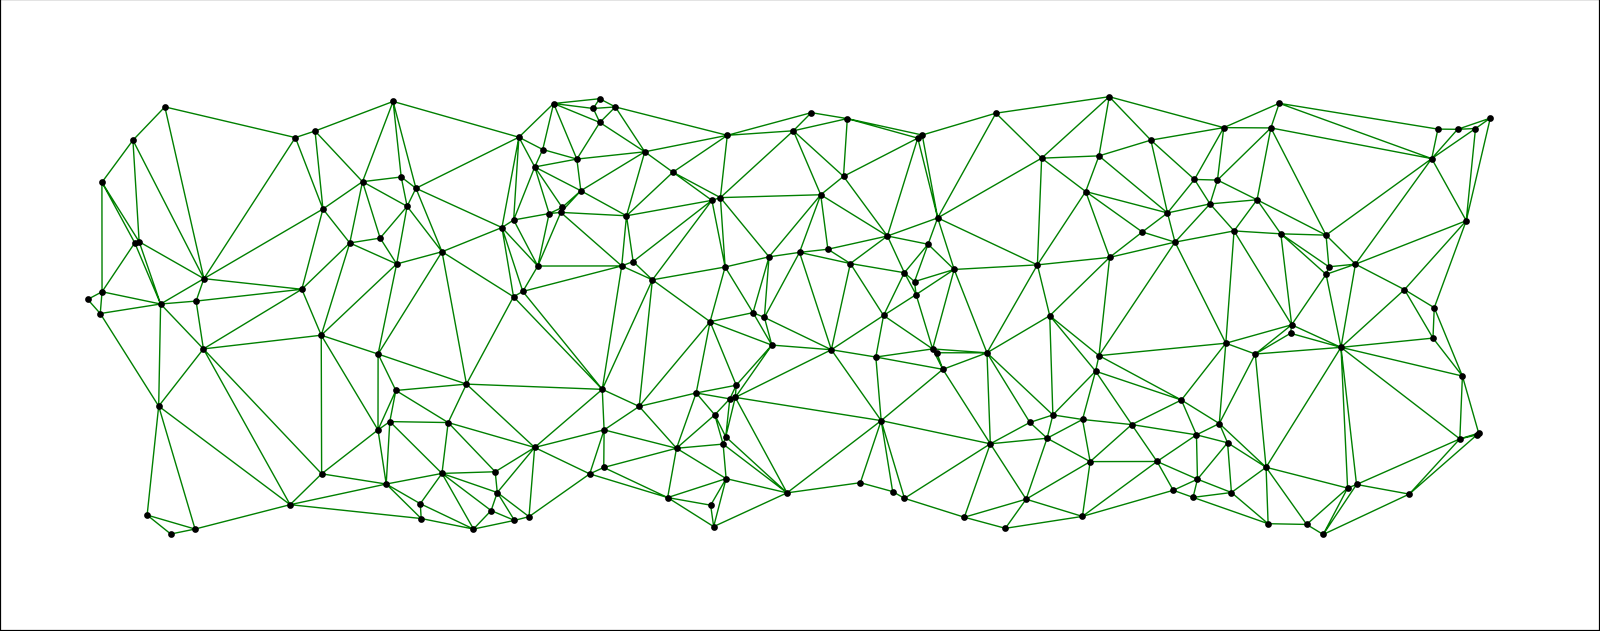

In [10]:
# Don't have a loop to plot yet, so we set PlotLoop = False
# We want to plot the triangulation at the intial time-slice, so
# set Initial = True
TopAdvec.Plot(PlotLoop = False, Initial = True)

### Plotting Parameters

The first step to plotting is to set the PlotParamters attribute of our TopAdvec object (there are default values, but you might want to change them). If you want to know the current set of values for the plotting parameters, use the PrintPlotParameters method:

In [12]:
TopAdvec.PrintPlotParameters()

filename: None
triplot: True
Delaunay: True
DelaunayAdd: False
Bounds: [[np.float64(-0.2541188960490385), np.float64(-1.2856526832198563)], [np.float64(6.260440517356644), np.float64(1.2856457131117405)]]
FigureSizeX: 8
dpi: 200
ptlabels: False
markersize: 2.0
linewidth_tri: 0.5
linecolor_tri: g
color_weights: False
log_color: True
color_map: inferno_r
linewidth_tt: 1.0
linecolor_tt: r
alpha_tt: 1.0
frac: 0.9
tt_lw_min_frac: 0.05
_conversion_factor: 0.011309998981607087
_max_weight: None
boundary_points: False
ExpandedBounds: [[np.float64(-0.5709352245502285), np.float64(-1.608066621771345)], [np.float64(6.577256845857834), np.float64(1.6080596516632293)]]


### Modifying Plotting Parameters

To modify the plotting parameters, we call the set SetPlotParameters method.  Let's view the boundary points by setting boundary_points = True, set the point maker size to be larger (markersize = 2), change the triangluation line color (linecolor_tri = 'c'), and line width (linewidth_tri = 1.5)

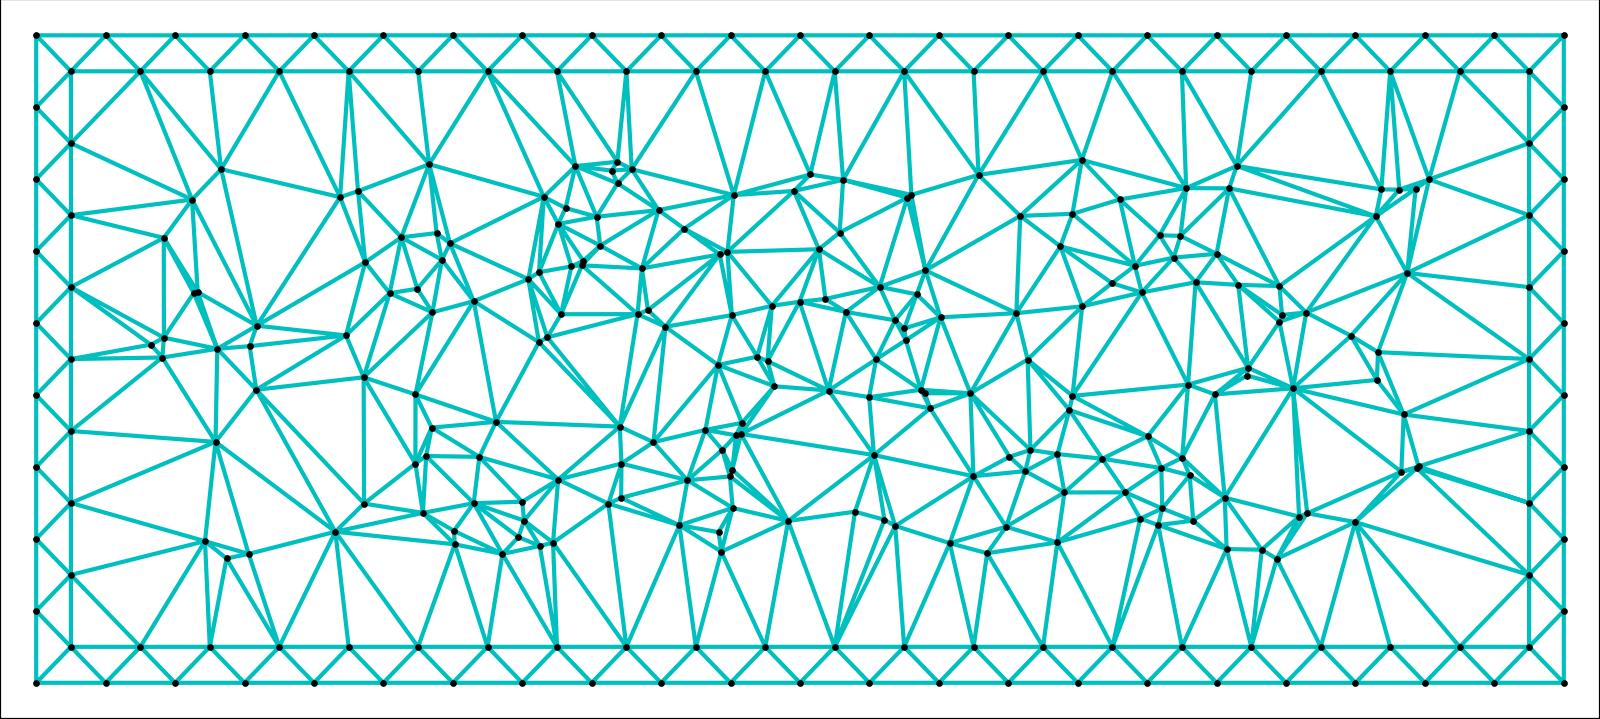

In [14]:
TopAdvec.SetPlotParameters(markersize = 2, boundary_points = True,
                           linecolor_tri = 'c', linewidth_tri = 1.5)
TopAdvec.Plot(PlotLoop = False, Initial = True)

To restore the default plotting parameters, use the ResetPlotParametersDefault method:

In [16]:
TopAdvec.ResetPlotParametersDefault()

### Finding Topological Entropy

Before getting to creating and plotting loops, let's take a look at one of the main things this algorithm was build for: finding the topological entropy of a flow (really a lower bound on this given the trajectory set).  To find the topological entropy simply use the GetTopologicalEntropy method:

In [18]:
# the TE, fitting error, and weight list are returned
# they are also set as attributes of TopAdvec, i.e. 
# TopAdvec.TopologicalEntropy = [TE, TE_err] and 
# TopAdvec.TotalWeightOverTime = WeightsM
TE, TE_err, Weights = TopAdvec.GetTopologicalEntropy()
print("The Topological Entropy is ", TE, " +/- ", TE_err)
# Note that a progress bar is displayed to give you a sense of how long the
# Triangulation evolution will take.

The Topological Entropy is  1.0042383528011265  +/-  0.006739992642712131===========================-] 99.0% ...


Note that the topological entropy is given in units of inverse time (which is set by your units for the time array).

The TE is calculated by fitting the log of the total weights (total weight is a measure of loop length) vs. time to a straight line (exponential stretching, so slope of this line is TE).  We can plot the weight data to see how good the fit is:

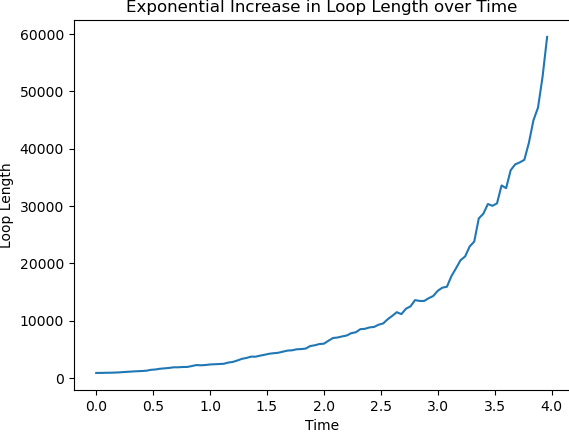

In [20]:
plt.plot(TopAdvec.Times, TopAdvec.TotalWeightOverTime)
plt.xlabel("Time")
plt.ylabel("Loop Length")
plt.title("Exponential Increase in Loop Length over Time")
plt.show()

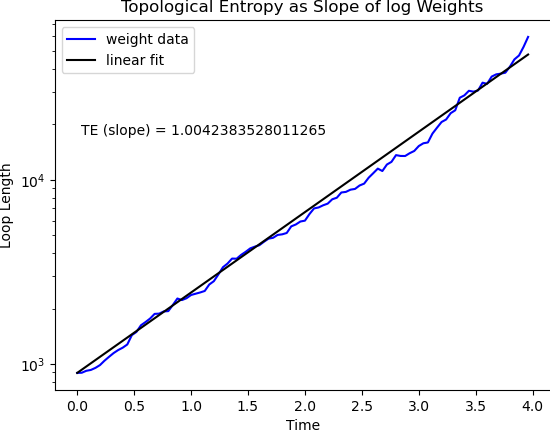

In [21]:
# Plotting with similogy to see the linear fit
W_0 = TopAdvec.TotalWeightOverTime[0]
T_0 = TopAdvec.Times[0]
TE = TopAdvec.TopologicalEntropy[0]
Weight_Fit = [W_0*np.exp(TE*(t-T_0)) for t in TopAdvec.Times]
plt.semilogy(TopAdvec.Times, TopAdvec.TotalWeightOverTime, c='b', label='weight data')
plt.semilogy(TopAdvec.Times, Weight_Fit, c='k', label='linear fit')
plt.xlabel("Time")
plt.ylabel("Loop Length")
plt.legend()
plt.title("Topological Entropy as Slope of log Weights")
ax = plt.gca()
plt.text(0.3, 0.7, 'TE (slope) = '+str(TE), horizontalalignment='center',
     verticalalignment='center', transform=ax.transAxes,fontsize = 10)
plt.show()

### Final Triangulation Plotting

The triangulation has been evolved forward as part of the topological entropy calculation, so we could plot the final triangulation:

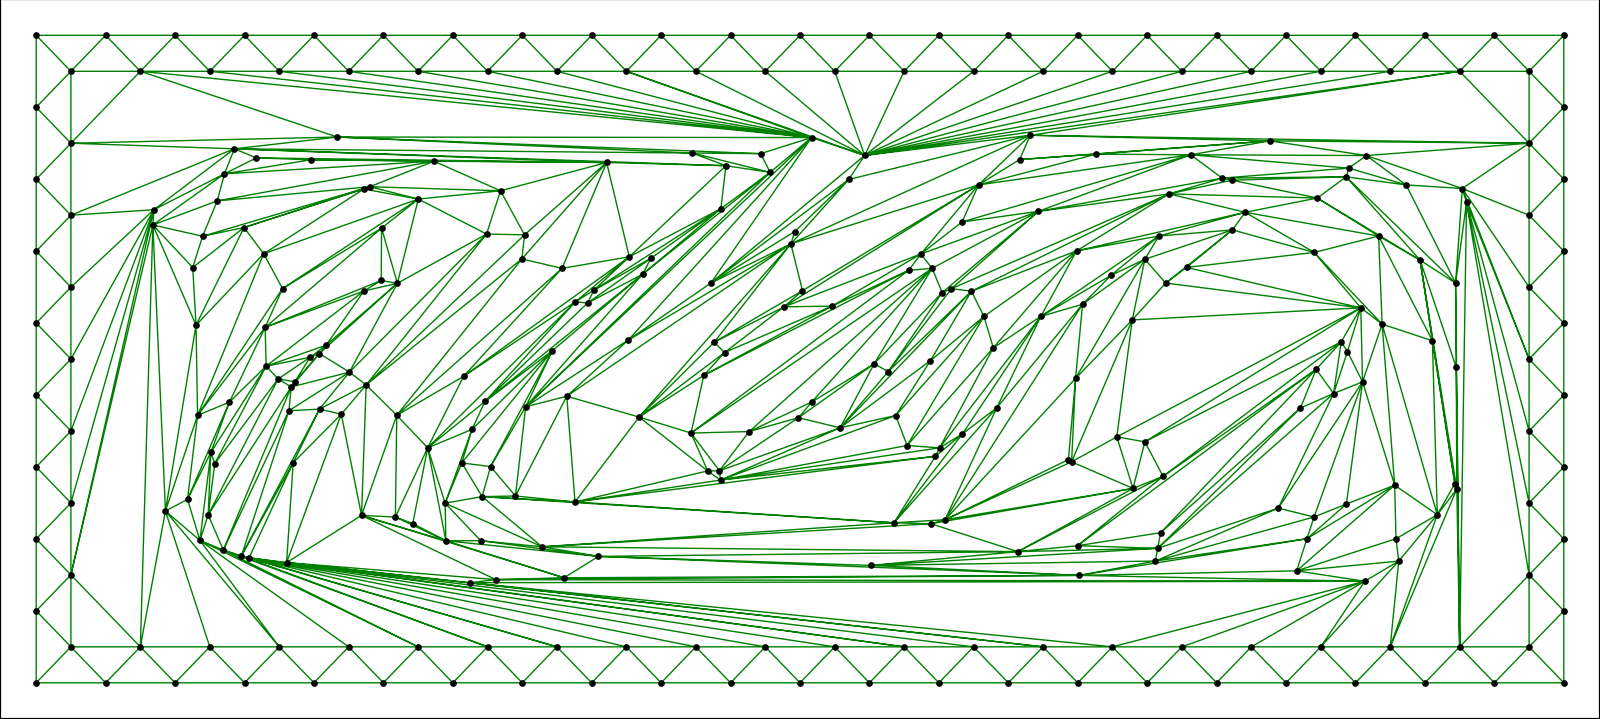

In [23]:
# Viewing with the boundary control points
TopAdvec.SetPlotParameters(boundary_points = True)
# note that we have set Initial = False to plot the final triangluation
TopAdvec.Plot(PlotLoop = False, Initial = False)

### Evolving the Triangulation

The above triangulation has a lot of long, skinny triangles in it, as the GetTopologicalEntropy method evolves the triangulation forward using collapse events only.  We certainly could use this to plot loops, but it looks much nicer to have a Delaunay triangulation.  One can re-evolve the triangulation with the Delaunay = True flag set.

[===================================================================================================-] 99.0% ...

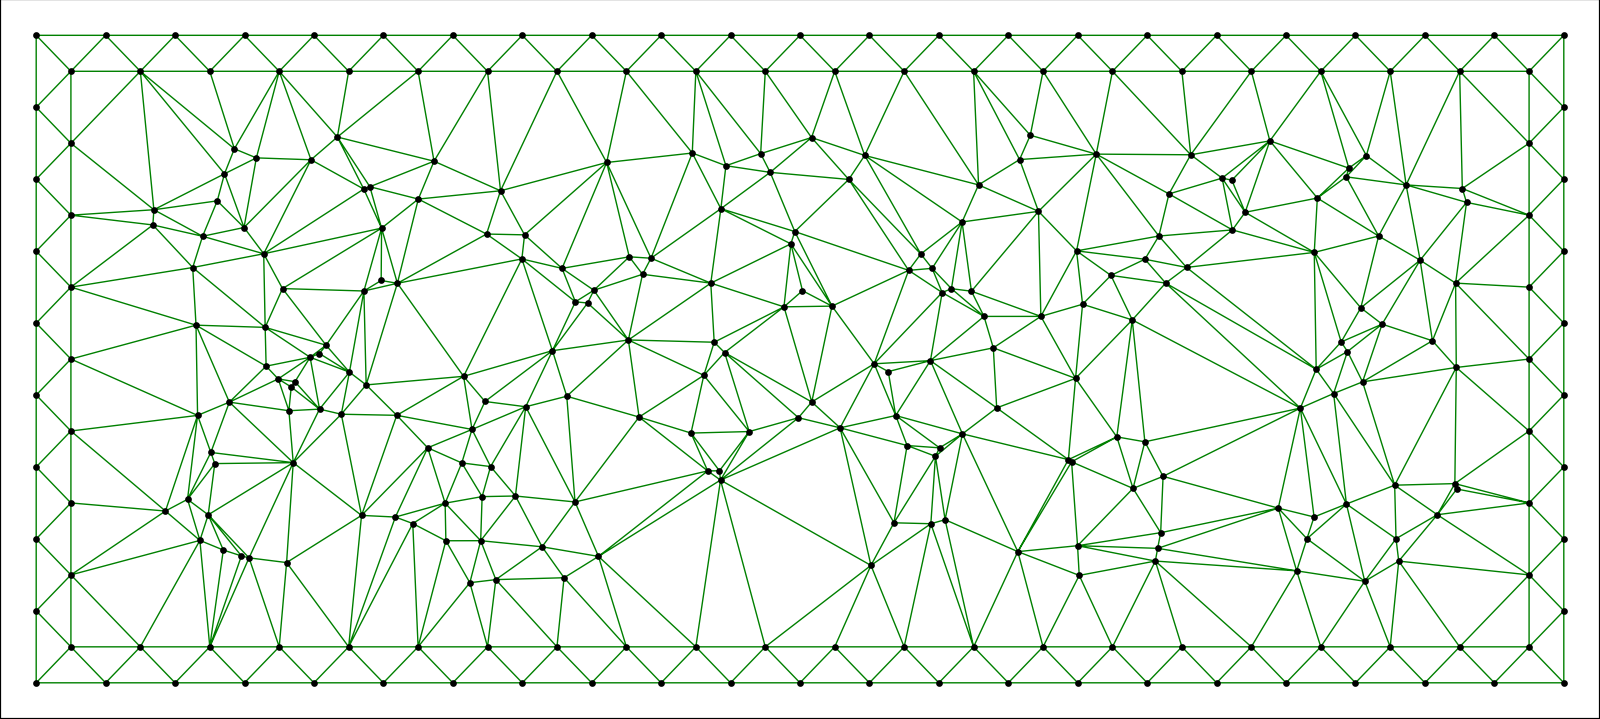

In [25]:
# Evolve the triangulation again, maintaining a Delaunay triangulation
TopAdvec.EvolveTri(Delaunay = True)
# plot the final triangulation again
TopAdvec.Plot(PlotLoop = False, Initial = False)

### Geometric Curves

Now let's see about initializing loops.  We do this using the CurveSet object (accessed as an attribute of our TopAdvec object).  This has methods for adding geometric curves to a curve set that will then be used to initialize a topological loop.  We'll look a a few examples:

In [27]:
# Don't need to clear the curve right now, but if there were any curves
# previously added to the curve set, we would need to clear them:
TopAdvec.ClearCurves()
# We add an ellipse to the curve set
TopAdvec.CurveSet.AddEllipse(center=[4.5, 0.0], a=1.0, b=0.5,
                             phi=np.pi/4, NumPoints=200)
# Add a vertical line to the curve set
TopAdvec.CurveSet.AddVerticalLine(x_val = 3.0)
# Add a custom curve to the curve set
x_pts = np.linspace(0.5, 2.5,100)
y_pts = np.square(x_pts-1.5)-0.5
points = np.array([x_pts,y_pts]).T
TopAdvec.CurveSet.AddOpenCurve(points)

### Topological Loop Initialization and Plotting

Now we initialize a topological loop with these accumulated geometric curves.  Note that while the curves are allowed to overlap (won't break anything), the way the crossings are re-connected is determined by the triangulation locally at the crossing point (which we don't control), so you should just make sure your curves do not overlap to begin with.

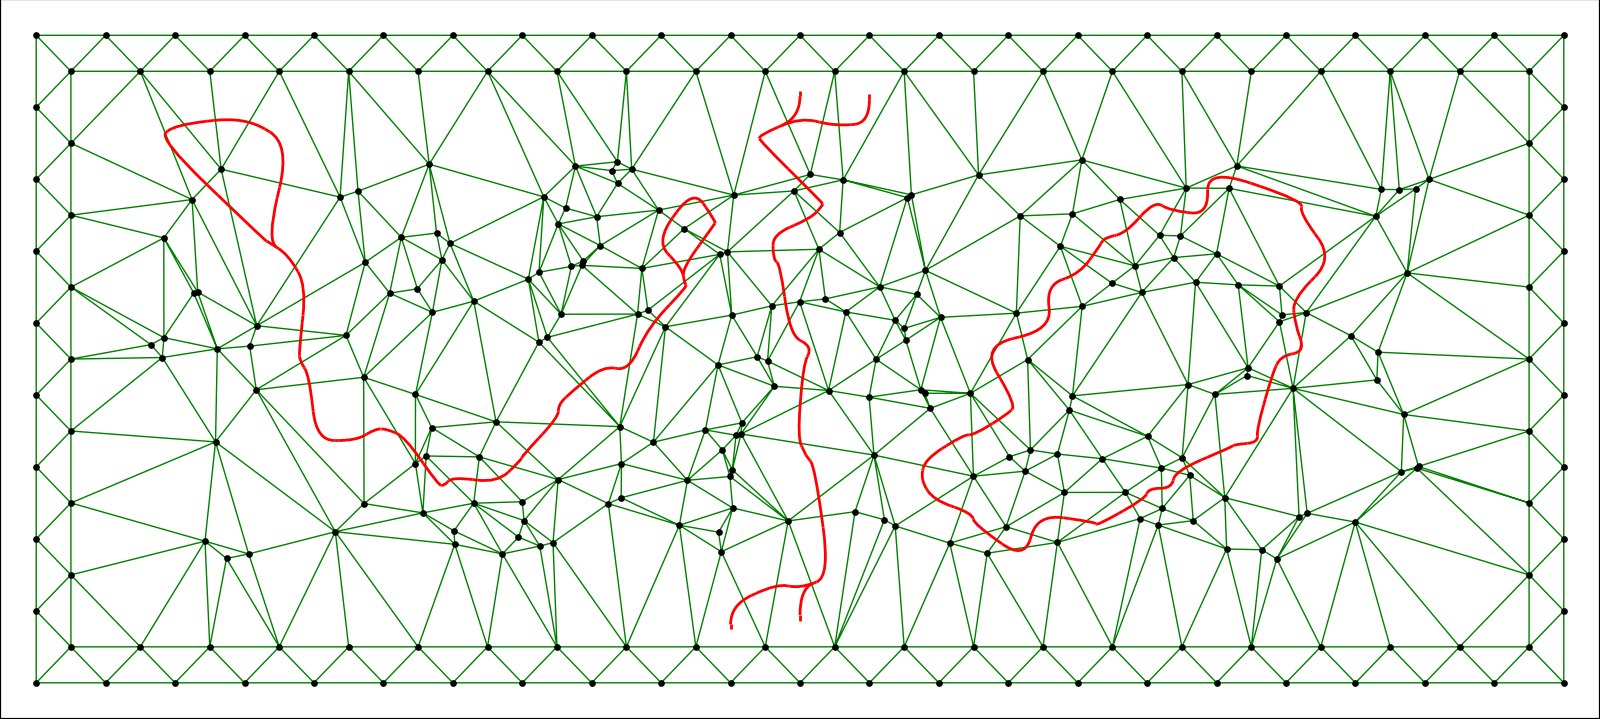

In [29]:
# First initialize the loop with the curves
TopAdvec.InitializeLoopWithCurves()
# now plot the topological loops
TopAdvec.Plot(Initial = True)  # note that PlotLoop = True is the default

A few things to note about loop plotting:  First, loops are topological objects, and what is plotted is neccesarily a particular geometric representation of the loop (based on using the Voronoi diagram dual to the Delaunay triangulation as control points).  This representation is topologically equivalent to the initializing geometric curves (can be deformed into one-another without going through the trajectory points - i.e. isotopic).  Second, geometric curves that are 'open' will have their ends wrap around the nearest point so that their loop is closed.  Third, what is being plotted is actually a train-track (segments of a loop that go though a given triangle are bundled together into one segment, which splits and merges with other segments; all while being tangent at splitting point).  As the loop becomes more convoluted, the train-track provides a way to visualize the aspects of the topological loop data.  What is lost in this representation is how many pieces of the loop have been bundled together (i.e. the weights/intersection coordinates).  In a moment we will see a few way to encode this information in the plot.

### Evolving Loops Forward

Now that the triangulation has been evolved forward to the final time (and therefore has accumulated an ordered list of weight operators), we can evolve any loop forward very efficiently (evolving a loop forward is a few orders of magnitude faster than evolving the whole triangulation forward).  To evolve the current loop forward just use the EvolveLoop method:

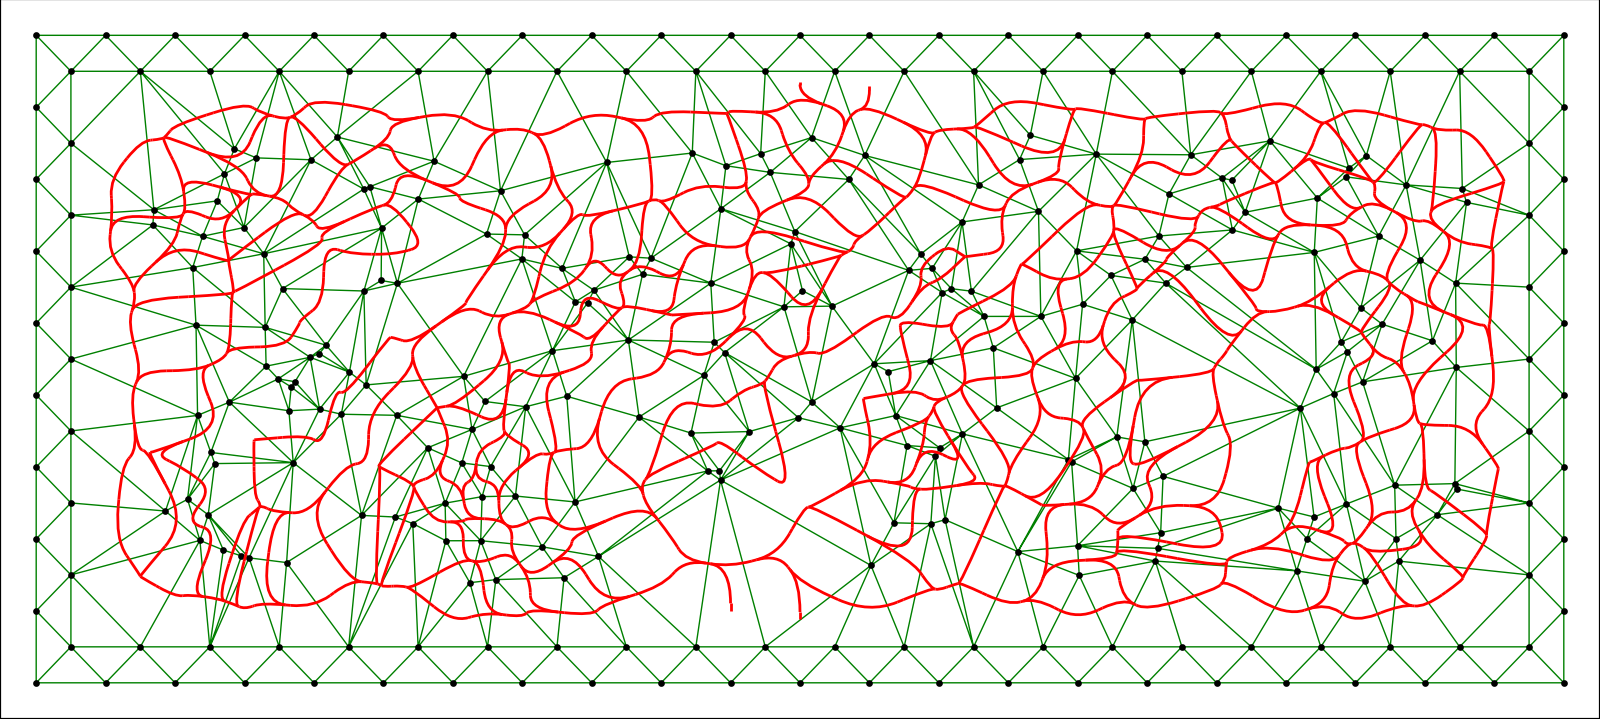

In [32]:
# Evolve the current loop forwards (there are actually two copies of the loop in the TopAdvec.LoodData object,
# and only one is evolved forwards - this is to allow plotting a given loop at both the initial and final times).
TopAdvec.EvolveLoop()
# Now plot the loop in its final state
TopAdvec.Plot(PlotLoop = True, Initial = False)

### Plotting Options for Highlighting Weights

The above train-tracks plot of the loop after being advected forwards fills up much of the domain (because this is a mixing flow).  You can see some sets of points that are not divided by the train-track - these are potential candidates for coherent structures/sets.  However, we don't know which of the weights are large and which are small.  There are two ways of highlighting weights when plotting: by color and by line width.  Lets' first consider color:

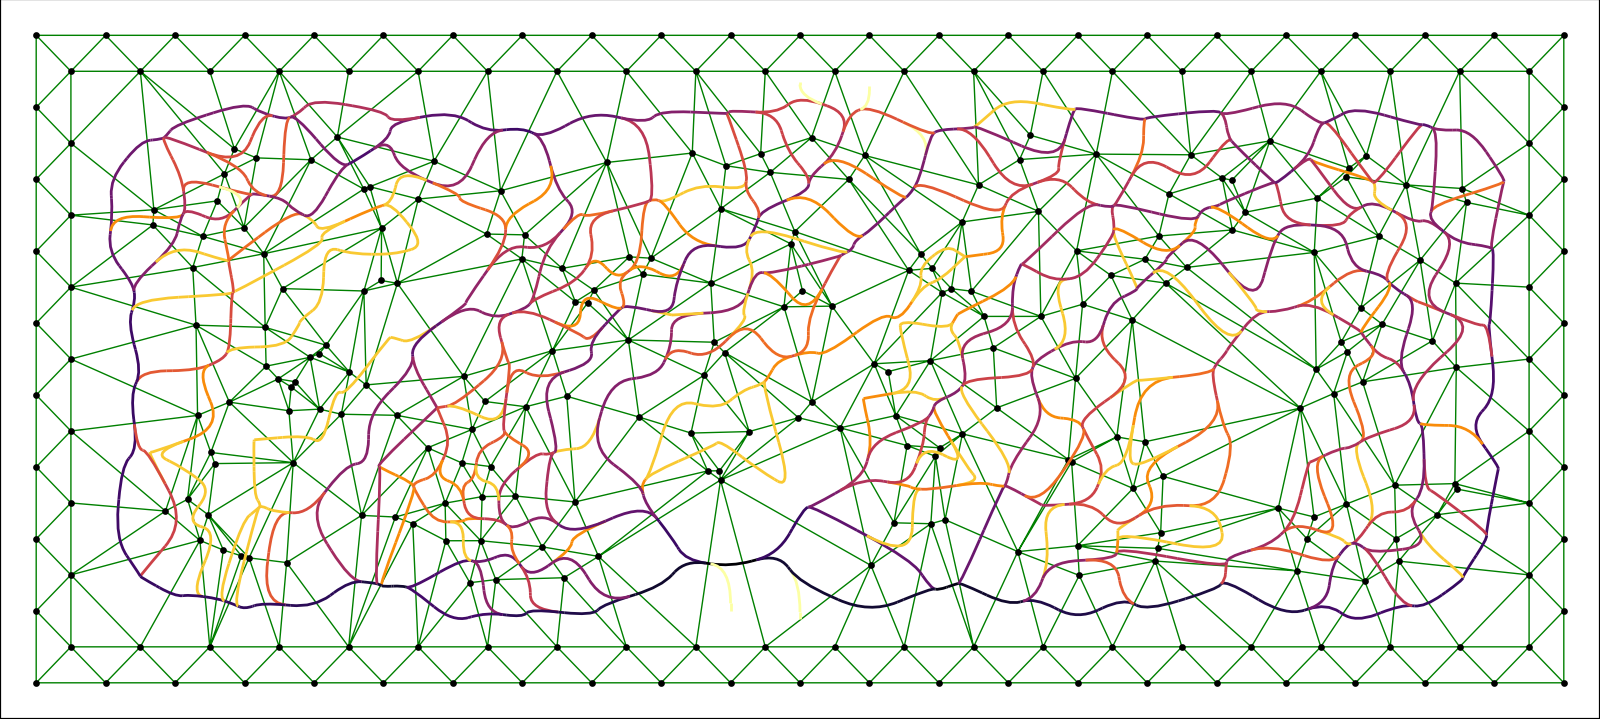

In [34]:
# Set the plot parameter color_weights to True.
TopAdvec.SetPlotParameters(color_weights = True)
TopAdvec.Plot(PlotLoop = True, Initial = False)

The darker train-track segments indicate larger weights, and the lighter are smaller weights.  The default setting for the color_map is 'inferno_r', which you can change if you have a favorite (try to use only perceptually uniform sequential color maps).  The default for how we assign a weight a color is given by log_color = True (the linear color scale is mapped onto the log of the weights, highlighting the full spectrum of weights).  For the next plot, let's set log_color = False, and let's turn off the background triangulation, which is getting crowded, and set the boundary back to normal:

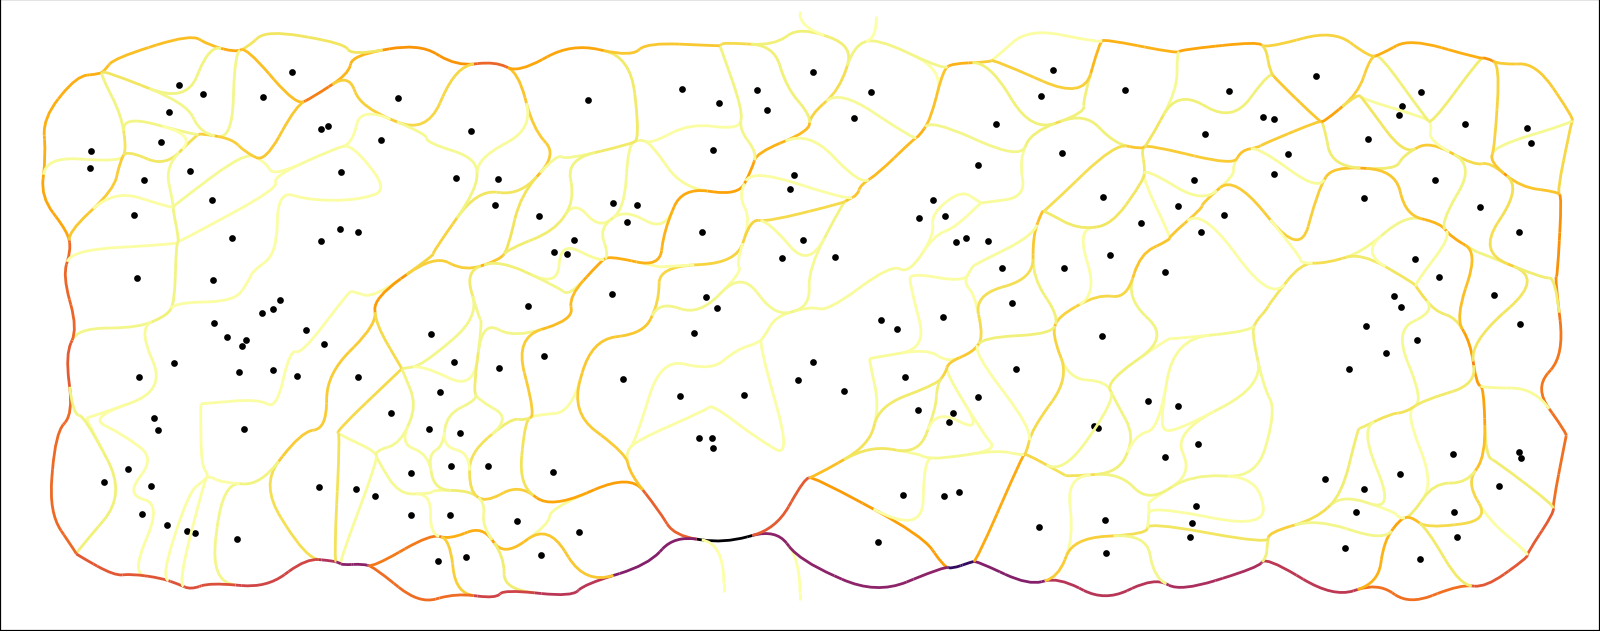

In [36]:
TopAdvec.SetPlotParameters(log_color = False, triplot = False, boundary_points = False)
TopAdvec.Plot(PlotLoop = True, Initial = False)

With the colors being linear in the weights, the plot highlights the very largest weights most.  Next, let's see how to encode the weight data in the width of the train-track segments.  We do this with the DelaunayAdd = True plot parameter.  We will also turn the color weights off.  The DelaunayAdd option plots the train-track segments with a line width that scales linearly with weight (max line width is set with linewidth_tt).  The individual segments then perceptually add as they merge at junctions.  A minimum linewidth (under which all lines are plotted with this width) is set using tt_lw_min_frac (default = 0.05 means a maximum linewidth of 10 gives a minimum linewidth of 0.5).

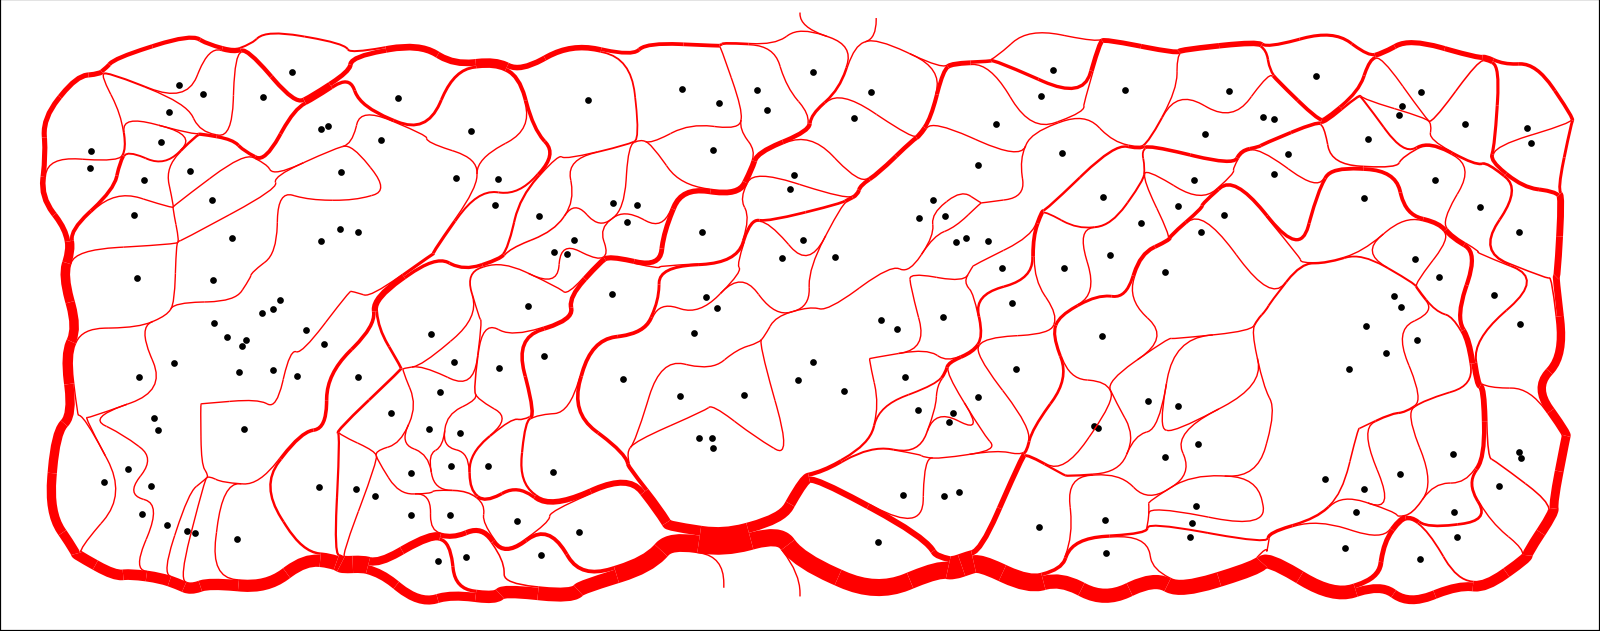

In [38]:
TopAdvec.SetPlotParameters(DelaunayAdd = True, linewidth_tt = 10.0, color_weights = False)
TopAdvec.Plot(PlotLoop = True, Initial = False)

The distribution of weights is now strikingly apparent.  If the original curve represented a material curve of dye in the fluid, this plot represents information on the relative dye concentration in different regions after being advected forward in time.

## Making Videos

We can also make a movie of the evolution of this loop using the MovieFigures method.  This creates figures of the loop/triangulation at each timestep and outputs them to a folder.  You can then use your favorite video editing software (like ffmpeg) to stitch these together into a movie.  For this option, it is best if the steps between timeslices are uniform.  Again the first step is to get your plotting attributes set the way you want them (these will be consistent across all the movie frames).

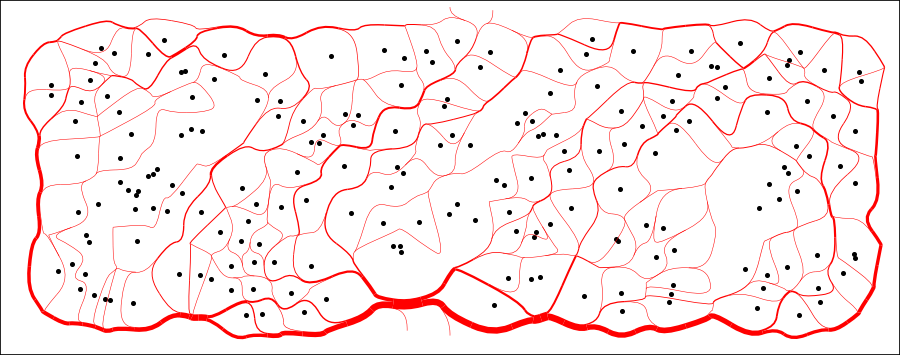

In [41]:
# Let's reduce the dpi (dot per inch) and FigureSizeX (width of the figure in inches - the height is automatically 
# set to maintain the aspect ratio), so that the image files will be smaller.
TopAdvec.SetPlotParameters(FigureSizeX = 6, dpi =  150, linewidth_tt = 5.0)
TopAdvec.Plot(PlotLoop = True, Initial = False)

In [42]:
# Now create the movie figures.  Will use the default settings for the folder name, file names,
# and file type:
TopAdvec.MovieFigures(PlotLoop=True, Delaunay=True, ImageFolder="MovieImages/",
                      ImageName="EvolvingLoop", filetype=".png")

[===================================================================================================-] 99.0% ...

Now to create the movie from the images, you can run ffmpeg with the following setup in your terminal:

ffmpeg -r 25 -i "MovieImages/EvolvingLoop%04d.png" -vcodec libx264 -crf 28 -pix_fmt yuv420p Videos/AdvectingLoop.mp4